In [14]:
%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import os.path
import sys
from scipy.stats import wasserstein_distance
from os import path
sns.set_theme(style="whitegrid")


In [74]:
dataset = "dblp_new_pubs"

In [75]:
scores_files_simple = ["sc_adamic_adar.csv", "sc_jaccard_coefficient.csv", "sc_resource_allocation.csv",
                "sc_preferential_attachment.csv", "sc_node2vec.csv"]

scores_files_fair = ["sc_fair.csv", "sc_dyadic_fair.csv", "sc_node2vec.csv", "sc_hybrid_node2vec.csv",
                "sc_hybrid_balanced_node2vec.csv"]

accept_prob_files = ["accept_prob_fair.csv", "accept_prob_dyadic_fair.csv",
                     "accept_prob_node2vec.csv","accept_prob_hybrid_node2vec.csv","accept_prob_hybrid_balanced_node2vec.csv"]

personalized_files = ["sc_personalized_dyadic_fair.csv_round_", "sc_personalized_fair.csv_round_",
                      "sc_personalized_node2vec.csv_round_",
                      "sc_personalized_hybrid_node2vec.csv_round_", "sc_personalized_hybrid_balanced_node2vec.csv_round_"]


In [76]:
def plot_scores_paper(dataset, scores_files):
    for sf in scores_files:
        df = pd.read_csv(dataset + "/" + sf)
        name = sf.split(".")[0].split("_")[1]
        # plt.title(dataset, fontsize=20)
        plt.plot(df["Rounds"], df["Scores"], label=name, linestyle=':', marker="*", linewidth=3, markersize=12)
        plt.ylabel('Scores', fontsize=20)
        plt.xlabel('Rounds', fontsize=20)
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        plt.title("Fair Score", fontsize=18)
        #plt.legend(bbox_to_anchor=(0.5, -0.5), loc='lower center', ncol=5, fontsize= 18, frameon=False)
        plt.legend()

In [77]:
def plot_accept_prob_paper(dataset, scores_files):
    for sf in accept_prob_files:
        df = pd.read_csv(dataset + "/" + sf)
        name = sf.split(".")[0].split("_")[2]
        plt.plot(df["Rounds"], df["Acceptance_prob"], label=name, linestyle=':', marker="*", linewidth=3, markersize=12)
        plt.ylabel('Acceptance_prob', fontsize=20)
        plt.xlabel('Rounds', fontsize=20)
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        plt.title("Acc. Prob", fontsize=18)
        plt.legend(bbox_to_anchor=(0.5, -0.5), loc='lower center', ncol=5, fontsize= 18, frameon=False)

In [78]:
def plot_personalized_dist(dataset, algorithm):
    distribution_distance = list()
    file_prefix = f"sc_personalized_{algorithm}.csv_round_"
    try:
        cat = pd.read_csv(f"{dataset}/out_community.txt", sep=" ", names=["Node", "Cat"], header=0)
    except:
        cat = pd.read_csv(f"{dataset}/out_community.txt", sep="\t", names=["Node", "Cat"], header=0)
    df = pd.read_csv(dataset + "/" + file_prefix + "-1.csv", sep="\t")
    fair_ratio = pd.read_csv("books/sc_personalized_node2vec.csv_round_-1.csv", sep="\t")["Red Personalized Pagerank"].mean()
    df = df.merge(cat, how="inner", on="Node")
    df["round"] = -1
    fair_ratio = pd.read_csv("books/sc_personalized_node2vec.csv_round_-1.csv", sep="\t")["Red Personalized Pagerank"].mean()
    temp_red = df.loc[df["Cat"] == 1]["Red Personalized Pagerank"]
    temp_blue = df.loc[df["Cat"] == 0]["Red Personalized Pagerank"]
    distribution_distance.append(wasserstein_distance(temp_red, temp_blue))
    for round in range(10):
        temp_df = pd.read_csv(dataset + "/" + file_prefix + f"{round}.csv", sep="\t")
        temp_df = temp_df.merge(cat, how="inner", on="Node")
        temp_red = temp_df.loc[temp_df["Cat"] == 1]["Red Personalized Pagerank"]
        temp_blue = temp_df.loc[temp_df["Cat"] == 0]["Red Personalized Pagerank"]
        distribution_distance.append(wasserstein_distance(temp_red, temp_blue))
        temp_df["round"] = round
        df = df.append(temp_df)
    fig = plt.figure(figsize=(15, 8))
    fig.suptitle(f"Dataset: {dataset} | Algorithm: {algorithm}")
    sns.violinplot(x="round", y="Red Personalized Pagerank", hue="Cat", data=df, split=True)
    
    return distribution_distance

In [79]:
def plot_unique_targets_paper(dataset, scores_files):
    unique_targets = dict()
    rounds = 11

    for sf in scores_files:
        df = pd.read_csv(f"{dataset}/" + sf)
        unique_targets[sf] = set()
        for r in range(1, rounds):
            edges = eval(df["Edges"][r])
            unique_targets[sf] = unique_targets[sf].union(set([j for i,j in edges]))
        unique_targets[sf] = list(unique_targets[sf])

    unique_targets_num = dict()
    for sf in scores_files:
        name = sf.split(".")[0].split("_")[1]
        unique_targets_num[sf] = len(unique_targets[sf])

    b = pd.DataFrame(unique_targets_num.items())
    g = sns.barplot(x=b[1], y=b[0])
    # plt.title(f"{dataset}", fontsize=20)
    # plt.ylabel("Policy", fontsize=20)
    plt.xlabel("#Unique Targets", fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(ticks=None, fontsize=20)
    # plt.legend(bbox_to_anchor=(0.5, -0.5), loc='lower center', ncol=5, fontsize= 18, frameon=False)
    print(unique_targets_num)

In [80]:
plot_scores_paper(dataset, scores_files_fair)

FileNotFoundError: [Errno 2] File dblp_new_pubs/sc_fair.csv does not exist: 'dblp_new_pubs/sc_fair.csv'

In [81]:
plot_accept_prob_paper(dataset, scores_files_fair)

FileNotFoundError: [Errno 2] File dblp_new_pubs/accept_prob_fair.csv does not exist: 'dblp_new_pubs/accept_prob_fair.csv'

In [82]:
dist_dist = dict()
dist_dist["node2vec"] = plot_personalized_dist(dataset, "node2vec")
dist_dist["hybrid_node2vec"] = plot_personalized_dist(dataset, "hybrid_node2vec")
dist_dist["fair"] = plot_personalized_dist(dataset, "fair")
dist_dist["balanced_fair"] = plot_personalized_dist(dataset, "dyadic_fair")
dist_dist["Hybrid_balanced_fair"] = plot_personalized_dist(dataset, "hybrid_balanced_node2vec")
dist_dist = pd.DataFrame.from_dict(dist_dist)

FileNotFoundError: [Errno 2] File dblp_new_pubs/sc_personalized_node2vec.csv_round_-1.csv does not exist: 'dblp_new_pubs/sc_personalized_node2vec.csv_round_-1.csv'

<IPython.core.display.Javascript object>


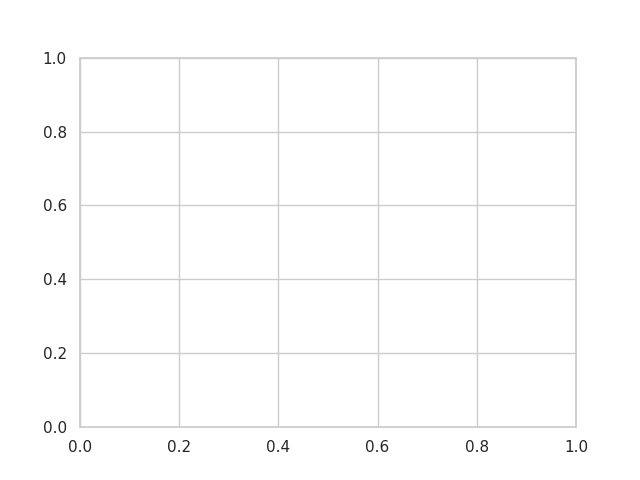

In [83]:
sns.lineplot(data = dist_dist)

In [73]:
plot_unique_targets_paper(dataset, scores_files_simple)

{'sc_adamic_adar.csv': 10832, 'sc_jaccard_coefficient.csv': 12735, 'sc_resource_allocation.csv': 11261, 'sc_preferential_attachment.csv': 680, 'sc_node2vec.csv': 1573}
